In [326]:
#####import libraries 
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import linalg as LA

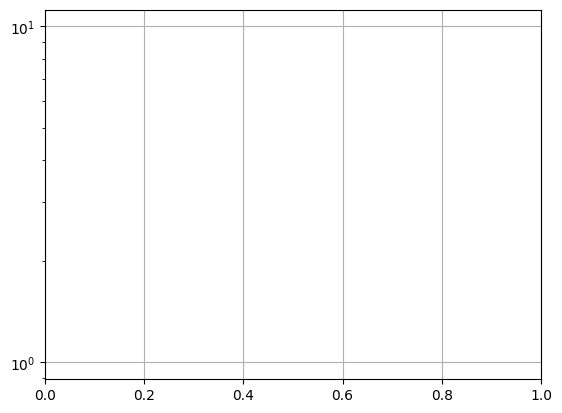

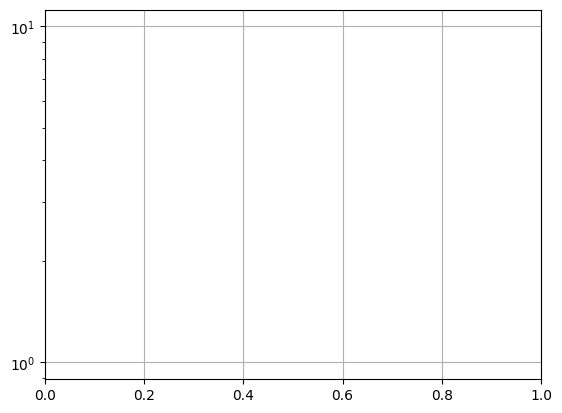

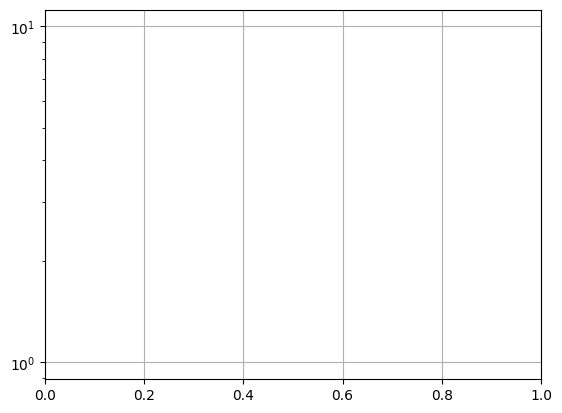

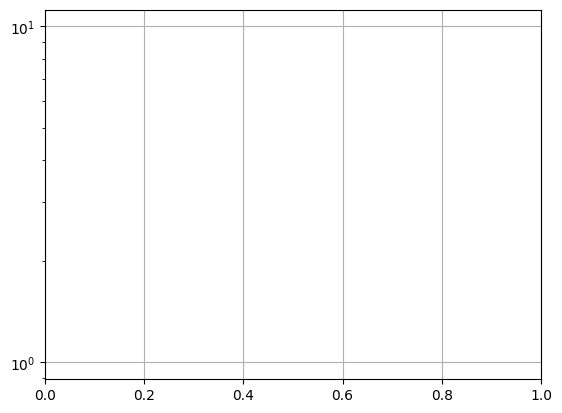

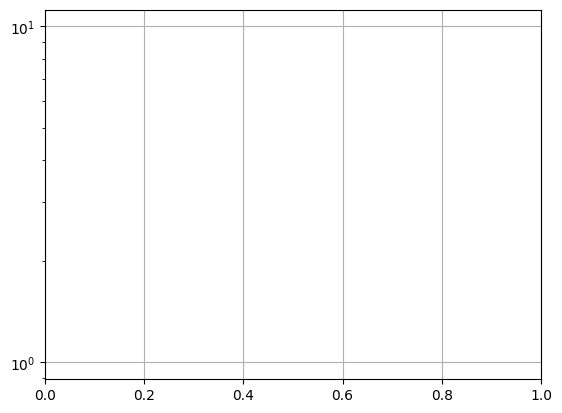

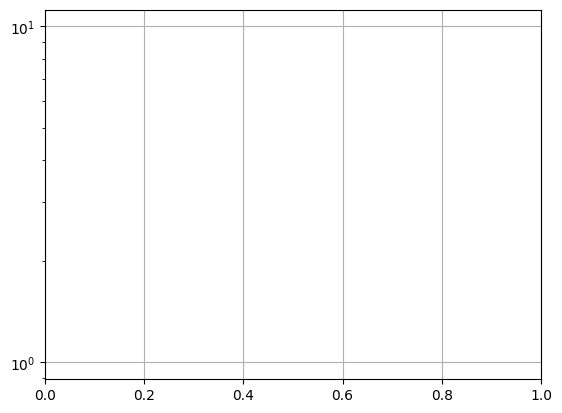

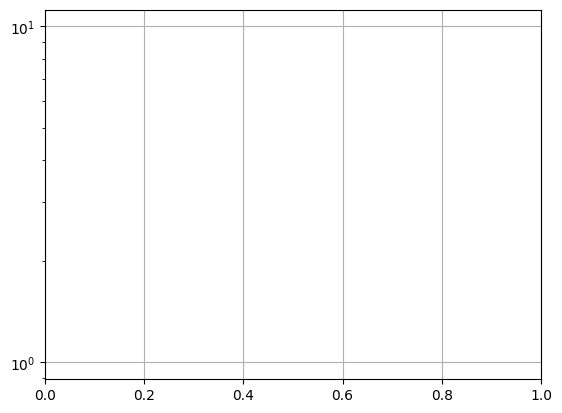

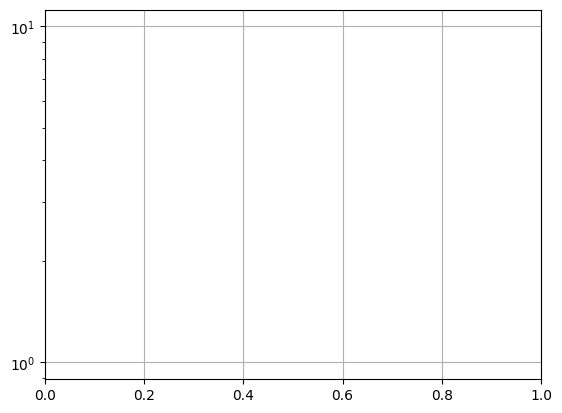

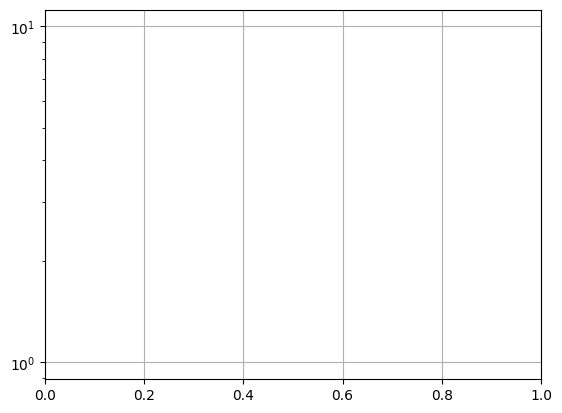

In [327]:
fig1 = plt.figure(1)
ax1 = fig1.gca()
ax1.set_yscale('log')
plt.grid()
fig2 = plt.figure(2)
ax2 = fig2.gca()
ax2.set_yscale('log')
plt.grid()
fig3 = plt.figure(3)
ax3 = fig3.gca()
ax3.set_yscale('log')
plt.grid()
fig4 = plt.figure(4)
ax4 = fig4.gca()
ax4.set_yscale('log')
plt.grid()
fig5 = plt.figure(5)
ax5 = fig5.gca()
ax5.set_yscale('log')
plt.grid()
fig6 = plt.figure(6)
ax6 = fig6.gca()
ax6.set_yscale('log')
plt.grid()
fig7 = plt.figure(7)
ax7 = fig7.gca()
ax7.set_yscale('log')
plt.grid()
fig8 = plt.figure(8)
ax8 = fig8.gca()
ax8.set_yscale('log')
plt.grid()
fig9 = plt.figure(9)
ax9 = fig9.gca()
ax9.set_yscale('log')
plt.grid()

In [328]:
######Fuction to generate invertible square matrix with size n
def invertible_matrix(n):
    randmx = np.random.rand(n,n)
    abs_sum_row = np.sum(np.abs(randmx),axis=1)
    np.fill_diagonal(randmx,abs_sum_row)
    randmx = randmx/(np.sum(randmx,axis=1))
    return randmx

######Function to genereate psd matrix with size n
def psd_matrix(n):
    randmx = np.random.normal(0,1, size=(n,n))
    return np.dot(randmx,randmx.T)


#####Function to genreate pd matrix with size n
def pd_matrix(n):    
    randmx = np.random.normal(0,1,size=(n,n))
    randmx = 1/2*(randmx + randmx.T)
    eigs,eigvectors = np.linalg.eig(randmx)
    eigs_p = np.abs(eigs)
    eigs_p = np.diag(eigs_p)
    return np.dot(np.dot(eigvectors,eigs_p),eigvectors.T)

#####Compute Gradients
def grad(x,y):
    dx = np.dot(C,y)
    dy = -np.dot(C,x)
    return dx,dy

#####Compute Gaussian Stochastic Oracles
def gaussian_noise(x,y,mu):
    std = 0.5
    noise = np.random.normal(mu,std,size=(2*n,1))
    dx,dy = grad(x,y)
    dx_noise = dx + noise[0:n]
    dy_noise = dy + noise[n:2*n]
    return dx_noise,dy_noise
#####Compute Scaled Gaussian Stochastic Oracles
def gaussian_noise_scaled(x,y,mu):
    scaling = 1e-2
    dist = np.sum(x**2 + y**2)
    std = scaling*dist
    noise = np.random.normal(mu,std,size=(2*n,1))
    dx,dy = grad(x,y)
    dx_noise = dx + noise[0:n]
    dy_noise = dy + noise[n:2*n]
    return dx_noise, dy_noise 

##three different noise settings
stochastic_oracle_d = lambda x, y: grad(x,y)
stochastic_oracle_affine = lambda x, y: gaussian_noise(x,y,mu)
stochastic_oracle_decaying =lambda x, y: gaussian_noise_scaled(x,y,mu)

In [329]:
#######Initialized parameters
####dimension of the dataset
n = 50
##########normal distribution parameters
mu = 0.0
seed = 0
random.seed(seed)
#####Generate pd matrix
C = pd_matrix(n)
# #####Generate psd matrix
######number of iterations
N=2000

markevery=N/100
########initialize x_0,y_0
x_0= np.random.normal(0,1,size=(n,1))
y_0 = np.random.normal(0,1,size=(n,1))

x_0 = x_0/ np.sqrt(np.sum(x_0**2 + y_0**2))
y_0 = y_0/ np.sqrt(np.sum(x_0**2 + y_0**2))

In [330]:
########AdaEG-Norm alg
def AdaEG_Norm(N,eta,x_0,y_0,stochastic_oracle):
    x,y = x_0,y_0
    dist_opt_hist = [np.sum(x**2 + y**2)]###record distance to the optimal solution, 0 in this case
    dist_opt_avg_hist= [np.sum(x**2 + y**2)]
    grad_x,grad_y = grad(x,y) 
    grad_norm = np.sum(grad_x**2 + grad_y**2)
    grad_norm_hist = [grad_norm]
    grad_norm_avg_hist = [grad_norm]
    x_sum = np.array(x_0)
    y_sum = np.array(y_0)
    stochastic_grad_x,stochastic_grad_y = stochastic_oracle(x,y)
    b_bar = 10e-2
    b_bar_hist = [b_bar]
    b = b_bar**2 ###compute b to the fourth in the alg
    N_iters = N
    for i in range(N_iters):
        ###update stepsize for extrapolation step 
        stochastic_grad = np.sum(stochastic_grad_x**2 + stochastic_grad_y**2)
        b = b + stochastic_grad
        alpha = eta[0]/np.power(b,1/4)
        ###update middle points
        x_bar = x - alpha*stochastic_grad_x 
        y_bar = y - alpha*stochastic_grad_y
        ###compute stochastic oracle at middle points
        stochastic_grad_x_bar,stochastic_grad_y_bar = stochastic_oracle(x_bar,y_bar)
        ###update stepsize for intrapolation step
        stochastic_grad_bar = np.sum(stochastic_grad_x_bar**2 + stochastic_grad_y_bar**2)
        b_bar = b_bar +stochastic_grad_bar + stochastic_grad
        b_bar_hist.append(b_bar)
        gamma = eta[1]/np.power(b_bar,1/2)
        ###update x,y
        x = x - gamma*stochastic_grad_x_bar
        y = y - gamma*stochastic_grad_y_bar
        #####record x,y
        #####record x,y
        x_sum = x_sum +np.array(x)
        y_sum = y_sum +np.array(y)
        #####record averaged iterates
        x_avg = x_sum / (i+1)
        y_avg= y_sum /(i+1)
        ###update stochastic oracle at x,y
        stochastic_grad_x,stochastic_grad_y = stochastic_oracle(x,y)
        ###record grad_norm at updated x,y
        grad_x,grad_y = grad(x,y) 
        grad_norm = np.sum(grad_x**2 + grad_y**2) 
        grad_norm_hist.append(grad_norm)
        ###record grad_norm_avg 
        grad_norm_avg_hist.append(np.sum(grad_norm_hist)/len(grad_norm_hist))
        ###record the distance to the optimal solution
        dist_opt_hist.append(np.sum(x_bar**2 + y_bar**2))
        dist_opt_avg_hist.append(np.sum(x_avg**2 + y_avg**2))
    return grad_norm_avg_hist,dist_opt_avg_hist,dist_opt_hist
###Initialize the paramters
eta = [1,1]

In [331]:
####Run 20 loops and get the mean value
N_loop = 20
grad_norm_avg_hist_affine_dict = dict()
grad_norm_avg_hist_decaying_dict = dict()
dist_opt_avg_hist_affine_dict= dict()
dist_opt_hist_affine_dict= dict()
dist_opt_avg_hist_decaying_dict= dict()
dist_opt_hist_decaying_dict= dict()
for i in range(N_loop):
    grad_norm_avg_hist_affine_dict[i],dist_opt_avg_hist_affine_dict[i],dist_opt_hist_affine_dict[i] = AdaEG_Norm(N,eta,x_0,y_0,stochastic_oracle_affine)
    grad_norm_avg_hist_decaying_dict[i],dist_opt_avg_hist_decaying_dict[i],dist_opt_hist_decaying_dict[i] = AdaEG_Norm(N,eta,x_0,y_0,stochastic_oracle_decaying)
import pandas as pd
pd1 = pd.DataFrame(grad_norm_avg_hist_affine_dict)
grad_norm_avg_hist_affine = np.sum(pd1,axis = 1)/N_loop
pd2 = pd.DataFrame(dist_opt_avg_hist_affine_dict)
dist_opt_avg_hist_affine = np.sum(pd2,axis=1)/N_loop
pd3 = pd.DataFrame(dist_opt_hist_affine_dict)
dist_opt_hist_affine= np.sum(pd3, axis = 1)/N_loop

pd4 = pd.DataFrame(grad_norm_avg_hist_decaying_dict)
grad_norm_avg_hist_decaying = np.sum(pd4,axis = 1)/N_loop
pd5 = pd.DataFrame(dist_opt_avg_hist_decaying_dict)
dist_opt_avg_hist_decaying = np.sum(pd5,axis=1)/N_loop
pd6 = pd.DataFrame(dist_opt_hist_decaying_dict)
dist_opt_hist_decaying= np.sum(pd6, axis = 1)/N_loop

In [332]:
ax2.plot(dist_opt_hist_affine,markevery=markevery, marker = '.',label='AdaEG-S')
ax3.plot(dist_opt_hist_decaying,markevery=markevery, marker = '.',label='AdaEG-S')
ax5.plot(grad_norm_avg_hist_affine,markevery=markevery, marker = '.',label='AdaEG-S')
ax6.plot(grad_norm_avg_hist_decaying,markevery=markevery, marker = '.',label='AdaEG-S')
ax8.plot(dist_opt_avg_hist_affine,markevery=markevery, marker = '.',label='AdaEG-S')
ax9.plot(dist_opt_avg_hist_decaying,markevery=markevery, marker = '.',label='AdaEG-S')

In [333]:
######Two time scale_decaying stepsize
def DSEG(N,l_step,s_step,denom,x_0,y_0,stochastic_oracle):
    
    x,y = x_0,y_0
    longer_stepsize = l_step
    shorter_stepsize = s_step
    dist_opt_hist = [np.sum(x**2 + y**2)] ###record distance to the optimal solution, 0 in this case
    grad_x,grad_y = grad(x,y) 
    grad_norm = np.sum(grad_x**2 + grad_y**2)
    grad_norm_hist = [grad_norm]
    grad_norm_avg_hist = [grad_norm]
    dist_opt_avg_hist=[np.sum(x**2 + y**2)]
    x_sum=np.array(x_0)
    y_sum = np.array(y_0)
    stochastic_grad_x,stochastic_grad_y = stochastic_oracle(x,y)
    N_iters = N
    for i in range(N_iters):
        ###update stepsize for extrapolation step 
        alpha = longer_stepsize/(np.power(i+denom,0.1))
        ###update middle points
        x_bar = x - alpha*stochastic_grad_x 
        y_bar = y - alpha*stochastic_grad_y
#       ###compute stochastic oracle at middle points
        stochastic_grad_x_bar,stochastic_grad_y_bar = stochastic_oracle(x_bar,y_bar)
#       ###update stepsize for intrapolation step
        gamma = shorter_stepsize/(np.power(i+denom,0.9))
        ###update x,y
        x = x - gamma*stochastic_grad_x_bar
        y = y - gamma*stochastic_grad_y_bar
        ###update stochastic oracle at x,y
        stochastic_grad_x,stochastic_grad_y = stochastic_oracle(x,y)
        #####record x,y
        x_sum = x_sum +np.array(x)
        y_sum = y_sum +np.array(y)
        #####record averaged iterates
        x_avg = x_sum / (i+1)
        y_avg= y_sum /(i+1)
        ###record grad_norm at updated x,y
        grad_x,grad_y = grad(x,y) 
        grad_norm = np.sum(grad_x**2 + grad_y**2) 
        grad_norm_hist.append(grad_norm)
#         ###record grad_norm_avg 
        grad_norm_avg_hist.append(np.sum(grad_norm_hist)/len(grad_norm_hist))
        ###record the distance to the optimal solution
        dist_opt_hist.append(np.sum(x**2 + y**2))
        dist_opt_avg_hist.append(np.sum(x_avg**2+y_avg**2))
    return grad_norm_avg_hist,dist_opt_avg_hist,dist_opt_hist

###Initialize the parameters
denom = 19
l_step = 1
s_step = 0.1

In [334]:
####Run 20 loops and get the mean value
N_loop = 20
grad_norm_avg_hist_affine_dict = dict()
grad_norm_avg_hist_decaying_dict = dict()
dist_opt_avg_hist_affine_dict= dict()
dist_opt_hist_affine_dict= dict()
dist_opt_avg_hist_decaying_dict= dict()
dist_opt_hist_decaying_dict= dict()
for i in range(N_loop):
    grad_norm_avg_hist_affine_dict[i],dist_opt_avg_hist_affine_dict[i],dist_opt_hist_affine_dict[i] = DSEG(N,l_step,s_step,denom,x_0,y_0,stochastic_oracle_affine)
    grad_norm_avg_hist_decaying_dict[i],dist_opt_avg_hist_decaying_dict[i],dist_opt_hist_decaying_dict[i] = DSEG(N,l_step,s_step,denom,x_0,y_0,stochastic_oracle_decaying)
import pandas as pd
pd1 = pd.DataFrame(grad_norm_avg_hist_affine_dict)
grad_norm_avg_hist_affine = np.sum(pd1,axis = 1)/N_loop
pd2 = pd.DataFrame(dist_opt_avg_hist_affine_dict)
dist_opt_avg_hist_affine = np.sum(pd2,axis=1)/N_loop
pd3 = pd.DataFrame(dist_opt_hist_affine_dict)
dist_opt_hist_affine= np.sum(pd3, axis = 1)/N_loop

pd4 = pd.DataFrame(grad_norm_avg_hist_decaying_dict)
grad_norm_avg_hist_decaying = np.sum(pd4,axis = 1)/N_loop
pd5 = pd.DataFrame(dist_opt_avg_hist_decaying_dict)
dist_opt_avg_hist_decaying = np.sum(pd5,axis=1)/N_loop
pd6 = pd.DataFrame(dist_opt_hist_decaying_dict)
dist_opt_hist_decaying= np.sum(pd6, axis = 1)/N_loop

In [335]:
ax2.plot(dist_opt_hist_affine,markevery=markevery, marker = '.',label='DSEG')
ax3.plot(dist_opt_hist_decaying,markevery=markevery, marker = '.',label='DSEG')
ax5.plot(grad_norm_avg_hist_affine,markevery=markevery, marker = '.',label='DSEG')
ax6.plot(grad_norm_avg_hist_decaying,markevery=markevery, marker = '.',label='DSEG')
ax8.plot(dist_opt_avg_hist_affine,markevery=markevery, marker = '.',label='DSEG')
ax9.plot(dist_opt_avg_hist_decaying,markevery=markevery, marker = '.',label='DSEG')

In [336]:
######DSEG two time scale stepsize - fixed (EG+)
def DSEG_fixed(N,l_step,s_step,denom,x_0,y_0,stochastic_oracle):
    
    x,y = x_0,y_0
    longer_stepsize = l_step
    shorter_stepsize = s_step
    dist_opt_hist = [np.sum(x**2 + y**2)] ###record distance to the optimal solution, 0 in this case
    grad_x,grad_y = grad(x,y) 
    grad_norm = np.sum(grad_x**2 + grad_y**2)
    grad_norm_hist = [grad_norm]
    grad_norm_avg_hist = [grad_norm]
    dist_opt_avg_hist=[np.sum(x**2 + y**2)]
    x_sum=np.array(x_0)
    y_sum = np.array(y_0)
    stochastic_grad_x,stochastic_grad_y = stochastic_oracle(x,y)
    N_iters = N
    for i in range(N_iters):
        ###update stepsize for extrapolation step 
        alpha = longer_stepsize/(np.power(denom,0.1))
        ###update middle points
        x_bar = x - alpha*stochastic_grad_x 
        y_bar = y - alpha*stochastic_grad_y
#       ###compute stochastic oracle at middle points
        stochastic_grad_x_bar,stochastic_grad_y_bar = stochastic_oracle(x_bar,y_bar)
#       ###update stepsize for intrapolation step
        gamma = shorter_stepsize/(np.power(denom,0.9))
        ###update x,y
        x = x - gamma*stochastic_grad_x_bar
        y = y - gamma*stochastic_grad_y_bar
        ###update stochastic oracle at x,y
        stochastic_grad_x,stochastic_grad_y = stochastic_oracle(x,y)
        #####record x,y
        x_sum = x_sum +np.array(x)
        y_sum = y_sum +np.array(y)
        #####record averaged iterates
        x_avg = x_sum / (i+1)
        y_avg= y_sum /(i+1)
        ###record grad_norm at updated x,y
        grad_x,grad_y = grad(x,y) 
        grad_norm = np.sum(grad_x**2 + grad_y**2) 
        grad_norm_hist.append(grad_norm)
#         ###record grad_norm_avg 
        grad_norm_avg_hist.append(np.sum(grad_norm_hist)/len(grad_norm_hist))
        ###record the distance to the optimal solution
        dist_opt_hist.append(np.sum(x**2 + y**2))
        dist_opt_avg_hist.append(np.sum(x_avg**2+y_avg**2))
    return grad_norm_avg_hist,dist_opt_avg_hist,dist_opt_hist

###Initialize the paramters
denom = 19
l_step = 1
s_step = 0.1

In [337]:
####Run 20 loops and get the mean value
N_loop = 20
grad_norm_avg_hist_affine_dict = dict()
grad_norm_avg_hist_decaying_dict = dict()
dist_opt_avg_hist_affine_dict= dict()
dist_opt_hist_affine_dict= dict()
dist_opt_avg_hist_decaying_dict= dict()
dist_opt_hist_decaying_dict= dict()
for i in range(N_loop):
    grad_norm_avg_hist_affine_dict[i],dist_opt_avg_hist_affine_dict[i],dist_opt_hist_affine_dict[i] = DSEG_fixed(N,l_step,s_step,denom,x_0,y_0,stochastic_oracle_affine)
    grad_norm_avg_hist_decaying_dict[i],dist_opt_avg_hist_decaying_dict[i],dist_opt_hist_decaying_dict[i] = DSEG_fixed(N,l_step,s_step,denom,x_0,y_0,stochastic_oracle_decaying)
import pandas as pd
pd1 = pd.DataFrame(grad_norm_avg_hist_affine_dict)
grad_norm_avg_hist_affine = np.sum(pd1,axis = 1)/N_loop
pd2 = pd.DataFrame(dist_opt_avg_hist_affine_dict)
dist_opt_avg_hist_affine = np.sum(pd2,axis=1)/N_loop
pd3 = pd.DataFrame(dist_opt_hist_affine_dict)
dist_opt_hist_affine= np.sum(pd3, axis = 1)/N_loop

pd4 = pd.DataFrame(grad_norm_avg_hist_decaying_dict)
grad_norm_avg_hist_decaying = np.sum(pd4,axis = 1)/N_loop
pd5 = pd.DataFrame(dist_opt_avg_hist_decaying_dict)
dist_opt_avg_hist_decaying = np.sum(pd5,axis=1)/N_loop
pd6 = pd.DataFrame(dist_opt_hist_decaying_dict)
dist_opt_hist_decaying= np.sum(pd6, axis = 1)/N_loop

In [338]:
ax2.plot(dist_opt_hist_affine,markevery=markevery, marker = '.',label='EG+')
ax3.plot(dist_opt_hist_decaying,markevery=markevery, marker = '.',label='EG+')
ax5.plot(grad_norm_avg_hist_affine,markevery=markevery, marker = '.',label='EG+')
ax6.plot(grad_norm_avg_hist_decaying,markevery=markevery, marker = '.',label='EG+')
ax8.plot(dist_opt_avg_hist_affine,markevery=markevery, marker = '.',label='EG+')
ax9.plot(dist_opt_avg_hist_decaying,markevery=markevery, marker = '.',label='EG+')

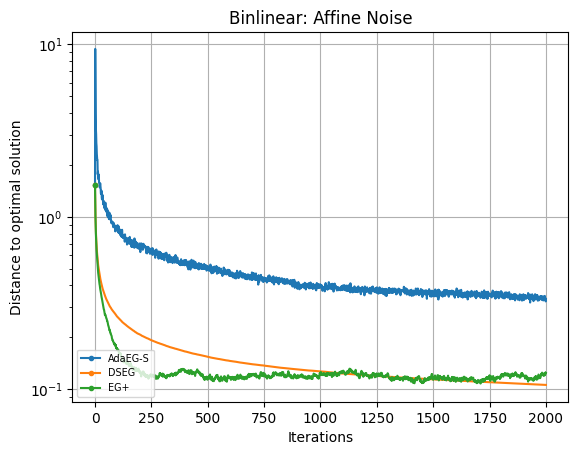

In [351]:
####under affine noise
ax2.set_title("Binlinear: Affine Noise")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Distance to optimal solution")
ax2.legend(loc=3,fontsize = 'x-small')
fig2
#fig2.savefig("bilinear_game_affine_noise_distance_to_opt")

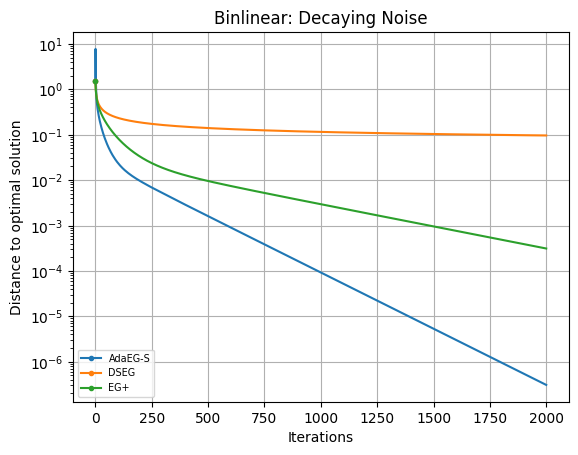

In [352]:
####under scaled noise
ax3.set_title("Binlinear: Decaying Noise")
ax3.set_xlabel("Iterations")
ax3.set_ylabel("Distance to optimal solution")
ax3.legend(loc=3, fontsize = 'x-small')
fig3
#fig3.savefig("bilinear_game_scaled_noise_distance_to_opt")

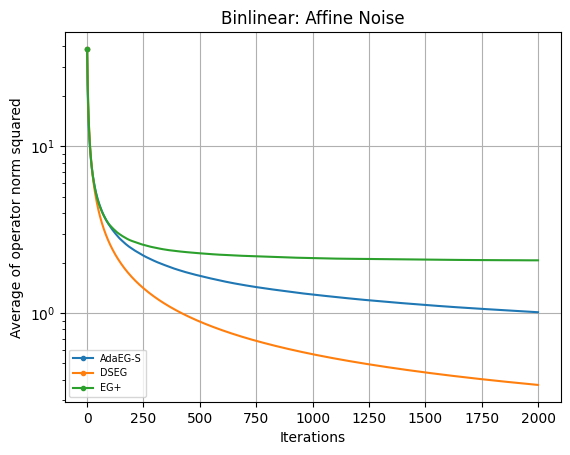

In [353]:
####under affine noise
ax5.set_title("Binlinear: Affine Noise")
ax5.set_xlabel("Iterations")
ax5.set_ylabel("Average of operator norm squared")
ax5.legend(loc=3,fontsize = 'x-small')
fig5
#fig5.savefig("bilinear_game_affine_noise_averaged_norm_square")

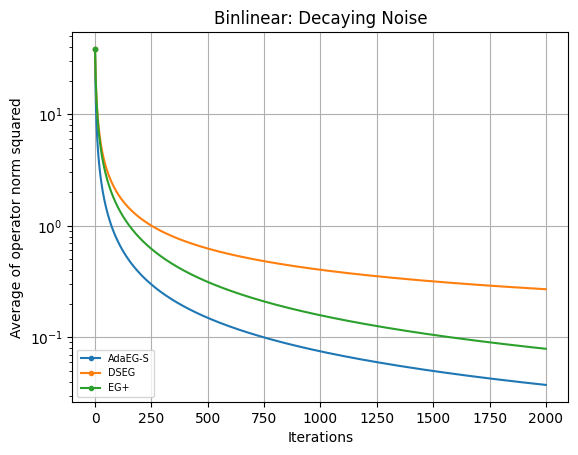

In [354]:
####under scaled noise
ax6.set_title("Binlinear: Decaying Noise")
ax6.set_xlabel("Iterations")
ax6.set_ylabel("Average of operator norm squared")
ax6.legend(loc=3, fontsize = 'x-small')
fig6
#fig6.savefig("bilinear_game_scaled_noise_averaged_norm_square")

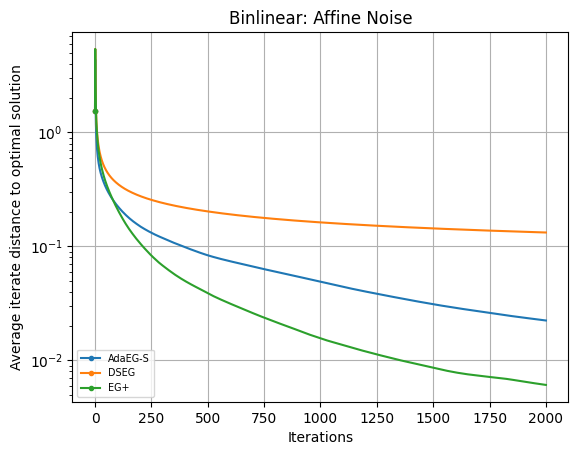

In [355]:
####under affine noise
ax8.set_title("Binlinear: Affine Noise")
ax8.set_xlabel("Iterations")
ax8.set_ylabel("Average iterate distance to optimal solution")
ax8.legend(loc=3,fontsize = 'x-small')
fig8
#fig8.savefig("bilinear_game_affine_noise_averaged_distance_to_opt")

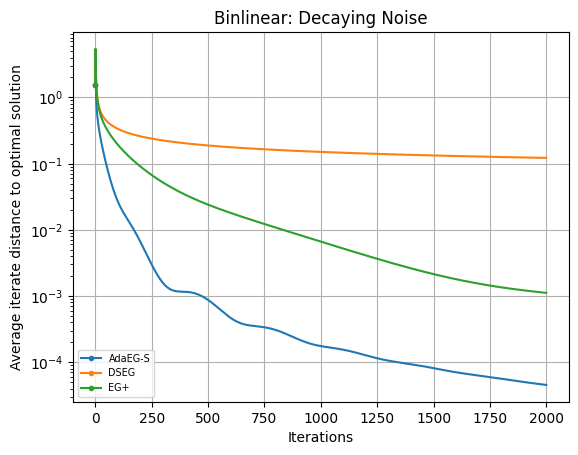

In [356]:
####under scaled noise
ax9.set_title("Binlinear: Decaying Noise")
ax9.set_xlabel("Iterations")
ax9.set_ylabel("Average iterate distance to optimal solution")
ax9.legend(loc=3, fontsize = 'x-small')
fig9
#fig9.savefig("bilinear_game_scaled_noise_averaged_distance_to_opt")